## Feature Selection
---
- 모델을 구성하는 주요 피처들을 선택
     - 불 필요한 다수의 피처들로 인해 모델 성능을 떨어뜨릴 가능성 제거
     - 설명 가능한 모델이 될 수 있도록 피처들을 선별

## Feature Selection 유형
---
- 피처 값의 분포, Null, 피처간 높은 상관도, 결정값과의 독립성등을 고려
- 모델의 피처 중요도 기반

## 사이킷런 Feature Selection 지원
---
- RFE(Recursive Feature Elimination)
    - 모델 최초 학습 후 Feature 중요도 선정
    - feature 중요도가 낮은 속성들을 차례로 제거해 가면서 반복적으로 학습/평가를 수행하여 최적 feature 추출
    - 수행시간이 오래 걸리고, 낮은 속성들을 제거해 나가는 메커니즘이 정확한 Feature Selectoin을 찾는 목표에 정확히 부합히자 않을 수 있음
- SelectFromModel
    - 모델 최초 학습 후 선정된 Feature 중요도에 따라 평균/중앙값의 특정 비율 이상인 Feature들을 선택

**RFE(Recursive Feature Elimination)**

Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.


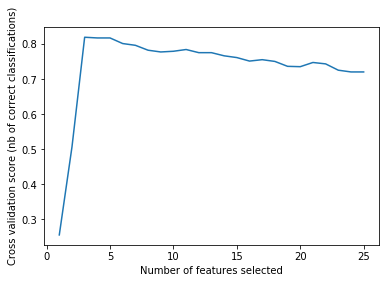

In [1]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV, RFE
from sklearn.datasets import make_classification

# 분류를 위한 Feature 개수가 25개인 데이터 1000개 생성
X, y = make_classification(n_samples=1000, n_features=25, n_informative=3,
                           n_redundant=2, n_repeated=0, n_classes=8,
                           n_clusters_per_class=1, random_state=0)

# SVC classifier 선택
svc = SVC(kernel="linear")
# REFCV로 Feature들을 반복적으로 제거해가면서 학습/평가 수행.  
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy', verbose=2)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

**SelectFromModel**

In [2]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, T-Cells (a type of white blood cells)
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, thyroid stimulating hormone
      - s5      ltg, lamotrigine
      - s6      glu, blood sugar level

Note: Each of these 10 feature va

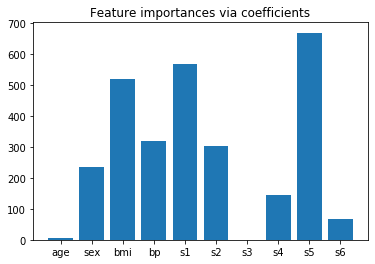

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LassoCV

lasso = LassoCV().fit(X, y)
importance = np.abs(lasso.coef_)
feature_names = np.array(diabetes.feature_names)
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.show()

In [4]:
from sklearn.feature_selection import SelectFromModel
from time import time

threshold = np.sort(importance)[-3] + 0.01
print('threshold:', threshold)

sfm = SelectFromModel(lasso, threshold='1.5 * median').fit(X, y)
print("Features selected by SelectFromModel: "
      f"{feature_names[sfm.get_support()]}")

threshold: 521.7485426067489
Features selected by SelectFromModel: ['bmi' 's1' 's5']


# Permutation Importance 개요
---
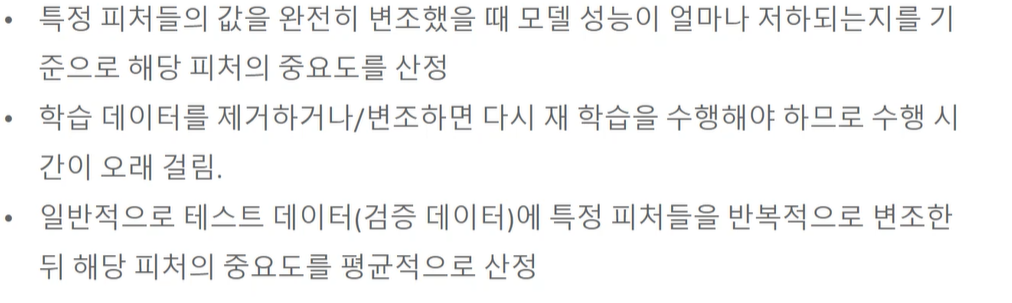

## Permutation importance 프로세스
---
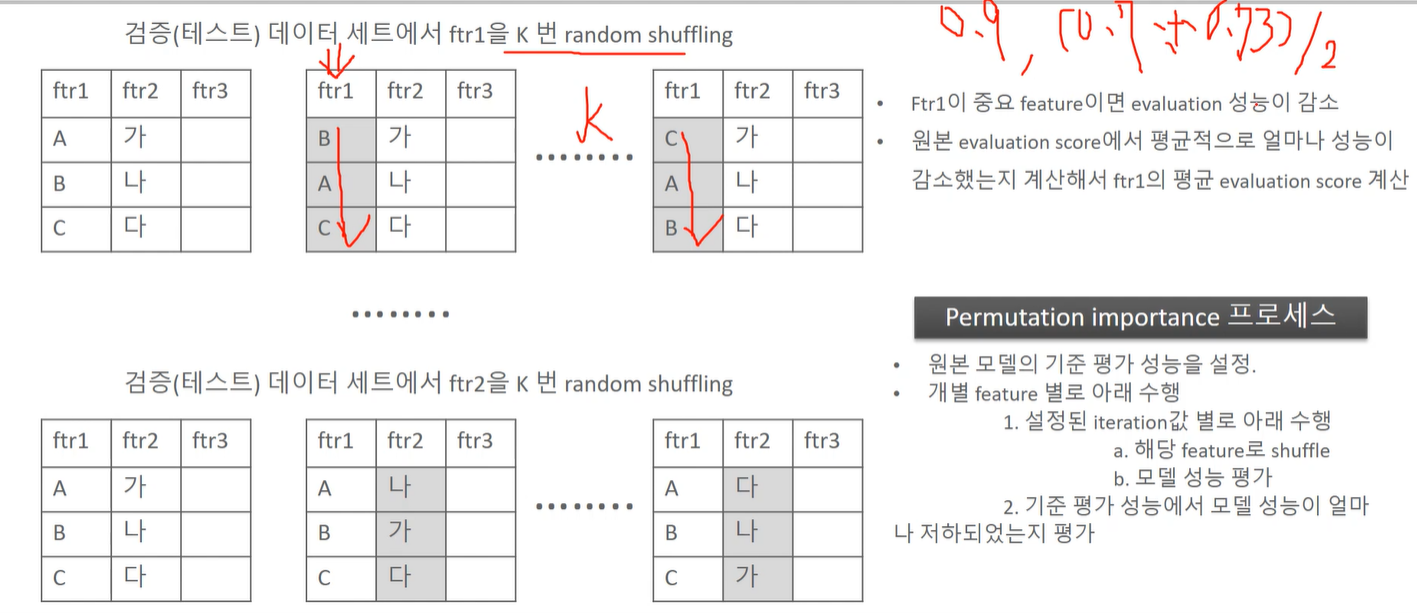

In [5]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

diabetes = load_diabetes()
X_train, X_val, y_train, y_val = train_test_split(diabetes.data, diabetes.target, random_state=0)

#학습, 예측, R2 Score 평가 
model = Ridge(alpha=1e-2).fit(X_train, y_train)
y_pred = model.predict(X_val)
print('r2 score:', r2_score(y_val, y_pred))

r2 score: 0.35666062386954545


In [6]:
from sklearn.inspection import permutation_importance

r = permutation_importance(model, X_val, y_val, n_repeats=30, random_state=0)

# 가장 평균 permutation importance가 높은 순으로 내림차순 정렬 후 평균 permutation importance값과 표준 편차 출력
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(diabetes.feature_names[i],"   ", np.round(r.importances_mean[i], 4), " +/- ", np.round(r.importances_std[i], 5))

s5     0.2042  +/-  0.04965
bmi     0.1758  +/-  0.0484
bp     0.0884  +/-  0.03284
sex     0.0559  +/-  0.02319


In [7]:
r.importances_mean

array([-0.00199267,  0.05587407,  0.17579   ,  0.08836513,  0.04221134,
        0.00203626,  0.00203754,  0.00318695,  0.20423412,  0.00278683])

## 왜 feature importance는 절대적인 feature selection 기준이 될 수 없는가 ?
---

- Feature importance는 최적 tree 구조를 만들기 위한 피처들의 impurity가 중요 기준임. 결정 값과 관련이 없어도 Feature importance가 높아 질 수있음.
- Feature importance는 학습 데이터를 기반으로 생성됨. 테스트 데이터에서는 달라질 수 있음
- Feature importance는 number 형의 높은 cardinality feature에 biased 되 있음.

**Permutation Importance vs Random Forest Feature Importance**

In [8]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [9]:
# titanic 데이터 세트 로딩. 
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

rng = np.random.RandomState(seed=42)
# 3가지 값으로 category값 random 설정. 
X['random_cat'] = rng.randint(3, size=X.shape[0])
# X건수만큼 고유한 random 값 설정. 
X['random_num'] = rng.randn(X.shape[0])

categorical_columns = ['pclass', 'sex', 'embarked', 'random_cat']
numerical_columns = ['age', 'sibsp', 'parch', 'fare', 'random_num']

X = X[categorical_columns + numerical_columns]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

# Null 값 처리, category 값 encoding 
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])

# 데이터 전처리 후 RandomForest로 학습 
rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(random_state=42))
])

rf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['pclass', 'sex', 'embarked',
                                                   'random_cat']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['age', 'sibsp', 'par

In [10]:
print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))

RF train accuracy: 1.000
RF test accuracy: 0.817


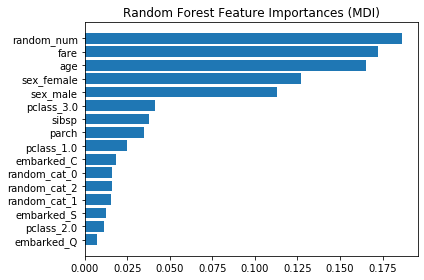

In [11]:
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

tree_feature_importances = (
    rf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

**검증 데이터 셋으로 permutation importance 수행**

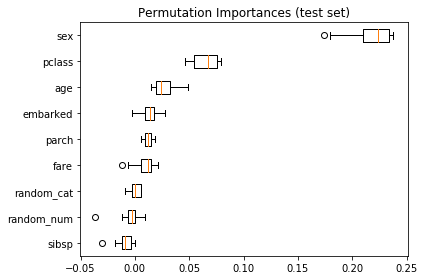

In [13]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()
